In [30]:
import pandas as pd
import numpy as np
import os
import timeit
import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [103]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

Let's inspect our target variable:

In [84]:
del y_train['id']

In [4]:
y_train['status_group'].value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [5]:
for i in X_train.columns:
    print i,',' ,'{:.1%}'.format(np.mean(X_train[i].isnull())),'nulls',',',type(X_train[i][0]), X_train[i].nunique()

id , 0.0% nulls , <type 'numpy.int64'> 59400
amount_tsh , 0.0% nulls , <type 'numpy.float64'> 98
date_recorded , 0.0% nulls , <type 'str'> 356
funder , 6.1% nulls , <type 'str'> 1897
gps_height , 0.0% nulls , <type 'numpy.int64'> 2428
installer , 6.2% nulls , <type 'str'> 2145
longitude , 0.0% nulls , <type 'numpy.float64'> 57516
latitude , 0.0% nulls , <type 'numpy.float64'> 57517
wpt_name , 0.0% nulls , <type 'str'> 37400
num_private , 0.0% nulls , <type 'numpy.int64'> 65
basin , 0.0% nulls , <type 'str'> 9
subvillage , 0.6% nulls , <type 'str'> 19287
region , 0.0% nulls , <type 'str'> 21
region_code , 0.0% nulls , <type 'numpy.int64'> 27
district_code , 0.0% nulls , <type 'numpy.int64'> 20
lga , 0.0% nulls , <type 'str'> 125
ward , 0.0% nulls , <type 'str'> 2092
population , 0.0% nulls , <type 'numpy.int64'> 1049
public_meeting , 5.6% nulls , <type 'bool'> 2
recorded_by , 0.0% nulls , <type 'str'> 1
scheme_management , 6.5% nulls , <type 'str'> 12
scheme_name , 47.4% nulls , <type '

In [459]:
X_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Variable Clean-up

### Variables to delete

In [85]:
def removal():
    # id: we drop the id column because it is not a useful predictor.
    # 'amount_tsh' is mostly blank - delete
    # wpt_name: not useful, delete (too many values)
    # subvillage: too many values, delete
    # scheme_name: this is almost 50% nulls, so we will delete this column
    # num_private: we will delete this column because ~99% of the values are zeros.
    # region: drop this b/c is seems very similar to region_code, though not 100% sure about this one!
    z = ['id', 'amount_tsh', 'num_private', 'wpt_name', 'subvillage', 'scheme_name', 'region', 
          'recorded_by', 'quantity', 'quality_group', 'source_type', 'payment', 'waterpoint_type_group',
         'extraction_type_group']
    for i in z:
        del X_train[i]
        del X_test[i]
    return

construction year: let's try filling in the nulls with the mean value

In [7]:
def construction():
    for i in [X_train, X_test]:
        i['construction_year'].replace(0, X_train['construction_year'].mean(), inplace=True)

date_recorded: this might be a useful variable for this analysis, although the year itself would be useless in a practical scenario moving into the future. We will convert this column into a datetime, and we will also create 'year_recorded' and 'month_recorded' columns just in case those levels prove to be useful. A visual inspection of both casts significant doubt on that possibility, but we'll proceed for now. We will delete date_recorded itself, since random forest cannot accept datetime

In [24]:
def dates():
    for i in [X_train, X_test]:
        i['date_recorded'] = pd.to_datetime(i['date_recorded'])
        i['date_recorded'] = pd.to_datetime(i['date_recorded'])
        i['year_recorded'] = i['date_recorded'].apply(lambda x: x.year)
        i['month_recorded'] = i['date_recorded'].apply(lambda x: x.month)
        i['high_season'] = i['date_recorded'].apply(lambda x: 1 if x.month in [6, 7, 8, 9] else 0)
        i['low_season'] = i['date_recorded'].apply(lambda x: 1 if x.month in [2, 3, 4, 5] else 0)
        i['shoulder_season'] = i['date_recorded'].apply(lambda x: 1 if x.month in [10, 11, 12, 1] else 0)
        del i['date_recorded']
    return

In [25]:
dates()

`gps_height`, `latitude`, `longitude`

In [9]:
def locs():
    trans = ['longitude', 'latitude', 'gps_height', 'population']
    for i in [X_train, X_test]:
        i.loc[i.longitude == 0, 'latitude'] = 0
        for z in trans:
            i[z].replace(0., np.NaN, inplace = True)
            i[z].replace(1., np.NaN, inplace = True)
            data = X_train.groupby(['subvillage'])[z]
            i[z] = data.transform(lambda x: x.fillna(x.mean()))
            data = X_train.groupby(['district_code'])[z]
            i[z] = data.transform(lambda x: x.fillna(x.mean()))
            data = X_train.groupby(['basin'])[z]
            i[z] = data.transform(lambda x: x.fillna(x.mean()))
            i[z] = i[z].fillna(X_train[z].mean())
    return

In [13]:
# public_meeting: we will fill the nulls as 'False'
# permit: we will fill the nulls as 'False'

def bools():
    z = ['public_meeting', 'permit']
    for i in z:
        X_train[i].fillna(False, inplace = True)
        X_train[i] = X_train[i].apply(lambda x: float(x))
        X_test[i].fillna(False, inplace = True)
        X_test[i] = X_test[i].apply(lambda x: float(x))
    return

string columns

In [10]:
def codes():
    # convert region_code and district_code to string objects, since they are actually categorical variables
    for i in ['region_code', 'district_code']:
        X_train[i] = X_train[i].apply(lambda x: str(x))
        X_test[i] = X_test[i].apply(lambda x: str(x))
    return

In [99]:
def dummies():
    start = timeit.default_timer()
    global X_train, X_test
    columns = [i for i in X_train.columns if type(X_train[i].iloc[1]) == str]
    for column in columns:
        X_train[column].fillna('NULL', inplace = True)
        good_cols = [column+'_'+i for i in X_train[column].unique() if i in X_test[column].unique()]
        X_train = pd.concat((X_train, pd.get_dummies(X_train[column], prefix = column)[good_cols]), axis = 1)
        X_test = pd.concat((X_test, pd.get_dummies(X_test[column], prefix = column)[good_cols]), axis = 1)
        del X_train[column]
        del X_test[column]
    print timeit.default_timer() - start, 'seconds'
    return

In [124]:
removal()
dummies()

65.5502892195 seconds


In [11]:
def meaningful():
    global X_train, X_test
    status = pd.get_dummies(y_train['status_group'])
    good_cols = []
    for i in X_train.columns[12:]:
        if status[X_train[i] == 1]['functional'].mean() > (status['functional'].mean() + .1):
            good_cols.append(i)
        elif status[X_train[i] == 1]['non functional'].mean() > (status['non functional'].mean() + .1):
            good_cols.append(i)
        elif status[X_train[i] == 1]['functional needs repair'].mean() > (status['functional needs repair'].mean() + .1):
            good_cols.append(i)
        X_train2 = pd.concat((X_train[:12], X_train[good_cols]), axis = 1)
        X_test2 = pd.concat((X_test[:12], X_test[good_cols]), axis = 1)
    return

In [18]:
construction()
locs()
dates()
bools()
codes()
removal()
dummies()

In [19]:
print np.shape(X_train)
print np.shape(X_test)

(59400, 3842)
(14850, 3842)


In [39]:
y = pd.get_dummies(y_train)

In [51]:
a = pd.concat((X_train, y_train), axis = 1).pivot_table(values = 'year_recorded', index = 'month_recorded', columns = 'status_group'
                   , aggfunc = 'count')

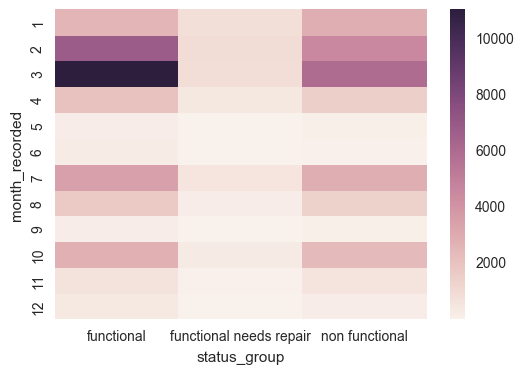

In [52]:
sns.heatmap(a)

### Dataset 1

In [8]:
import feature_process_helper
import pandas as pd
import numpy as np
import os

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [3]:
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [6]:
print np.shape(X_train)
print np.shape(X_test)

(59400, 2973)
(14850, 2973)


In [9]:
X_train.to_csv(os.path.join('clean_data', 'X_train1.csv'), index = False)
X_test.to_csv(os.path.join('clean_data', 'X_test1.csv'), index = False)

### Dataset 2

In [32]:
import feature_process_helper
import pandas as pd
import numpy as np
import os
from sklearn.externals import joblib

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [ ]:
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [19]:
corrs = {}

for i in X_train.columns:
    for z in X_train.columns:
        if i <> z and i.split('_') <> z.split('_') and i+'&'+z not in corrs and z+'&'+i not in corrs:
            if X_train[i].corr(X_train[z]) > .9:
                corrs[i+'&'+z] = X_train[i].corr(X_train[z])

In [34]:
joblib.dump(corrs, os.path.join('pickles', 'rf1_corr_dict.pkl'), 9)

['pickles\\rf1_corr_dict.pkl']

In [27]:
for z in [i.split('&')[1] for i in corrs.keys()]:
    del X_train[z]
    del X_test[z]

KeyError: 'extraction_type_class__wind-powered'